## Task 1

In [1]:
import pyspark
from pyspark.sql import functions as F

spark = pyspark.sql.SparkSession.builder \
    .appName("Project 4") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

In [2]:
df = spark.read.csv('./data/2009.csv', header=True, inferSchema=True)

In [3]:
from pathlib import Path

data_path = "./output/2009.parquet"
data_file = Path(data_path)
if not data_file.exists():

    df = spark.read.csv('./data/2009.csv', header=True)
    print(f"Total flights: {df.count()}")

    df_2009 = df.filter(F.year(F.col("FL_DATE")) == 2009)
    print(f"2009 flights: {df_2009.count()}")

    df_2009.write.partitionBy("FL_DATE").mode("overwrite").parquet(data_path)

df_flights = spark.read.load(data_path)

#test with smaller sample, since full dataset takes very long time with models
#df_flights = df_flights.sample(withReplacement=False, fraction=0.01, seed=42)


## Task 2

In [4]:

df_renamed = df_flights \
    .withColumnRenamed("FL_DATE", "FlightDate") \
    .withColumnRenamed("OP_CARRIER", "UniqueCarrier") \
    .withColumnRenamed("OP_CARRIER_FL_NUM", "FlightNum") \
    .withColumnRenamed("ORIGIN", "Origin") \
    .withColumnRenamed("DEST", "Destination") \
    .withColumnRenamed("CRS_DEP_TIME", "ScheduledDepartureTime") \
    .withColumnRenamed("DEP_TIME", "DepartureTime") \
    .withColumnRenamed("DEP_DELAY", "DepartureDelay") \
    .withColumnRenamed("TAXI_OUT", "TaxiOut") \
    .withColumnRenamed("WHEELS_OFF", "WheelsOff") \
    .withColumnRenamed("WHEELS_ON", "WheelsOn") \
    .withColumnRenamed("TAXI_IN", "TaxiIn") \
    .withColumnRenamed("CRS_ARR_TIME", "ScheduledArrivalTime") \
    .withColumnRenamed("ARR_TIME", "ArrivalTime") \
    .withColumnRenamed("ARR_DELAY", "ArrivalDelay") \
    .withColumnRenamed("CANCELLED", "Cancelled") \
    .withColumnRenamed("CANCELLATION_CODE", "CancellationCode") \
    .withColumnRenamed("DIVERTED", "Diverted") \
    .withColumnRenamed("CRS_ELAPSED_TIME", "ScheduledElapsedTime") \
    .withColumnRenamed("ACTUAL_ELAPSED_TIME", "ActualElapsedTime") \
    .withColumnRenamed("AIR_TIME", "AirTime") \
    .withColumnRenamed("DISTANCE", "Distance") \
    .withColumnRenamed("CARRIER_DELAY", "CarrierDelay") \
    .withColumnRenamed("WEATHER_DELAY", "WeatherDelay") \
    .withColumnRenamed("NAS_DELAY", "NASDelay") \
    .withColumnRenamed("SECURITY_DELAY", "SecurityDelay") \
    .withColumnRenamed("LATE_AIRCRAFT_DELAY", "LateAircraftDelay") \
    .drop("Unnamed: 27")

df_renamed.show()

+-------------+---------+------+-----------+----------------------+-------------+--------------+-------+---------+--------+------+--------------------+-----------+------------+---------+----------------+--------+--------------------+-----------------+-------+--------+------------+------------+--------+-------------+-----------------+----------+
|UniqueCarrier|FlightNum|Origin|Destination|ScheduledDepartureTime|DepartureTime|DepartureDelay|TaxiOut|WheelsOff|WheelsOn|TaxiIn|ScheduledArrivalTime|ArrivalTime|ArrivalDelay|Cancelled|CancellationCode|Diverted|ScheduledElapsedTime|ActualElapsedTime|AirTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|FlightDate|
+-------------+---------+------+-----------+----------------------+-------------+--------------+-------+---------+--------+------+--------------------+-----------+------------+---------+----------------+--------+--------------------+-----------------+-------+--------+------------+------------+--------+---

In [5]:
df_with_features = df_renamed \
    .withColumn("DayOfWeek", F.dayofweek(F.col("FlightDate"))) \
    .withColumn("Month", F.month(F.col("FlightDate")))

In [6]:
# null_columns = [c for c in df_with_features.columns if df_with_features.filter(F.col(c).isNull()).count() > 0]
# null_columns

In [7]:
delays = [
    'DepartureDelay',
    'ArrivalDelay',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay']
times = [
    'DepartureTime',
    'TaxiOut',
    'WheelsOff',
    'WheelsOn',
    'TaxiIn',
    'ArrivalTime',
    'ActualElapsedTime',
    'AirTime']
cancellation = [
    'CancellationCode'
]

df_cleaned = df_with_features \
    .fillna("0", subset=delays) \
    .fillna("", subset=cancellation)

for col_name in times:
    df_cleaned = df_cleaned.withColumn(col_name, F.when((F.col("Cancelled") == 1) | (F.col("Diverted") == 1.0), 0).otherwise(F.col(col_name)))

df_cleaned = df_cleaned.filter(F.col("Diverted") == 0.0)

In [8]:
from functools import reduce

all_rows_count = df_cleaned.count()

not_null_condition = reduce(lambda x, y: x & y, [F.col(c).isNotNull() for c in df_cleaned.columns])
df_cleaned = df_cleaned.filter(not_null_condition)
cleaned_rows_count = df_cleaned.count()

print(f"Found {all_rows_count - cleaned_rows_count} rows with unjustified NULL values. Removing them.")

Found 1 rows with unjustified NULL values. Removing them.


In [9]:
# null_condition = [(F.col(c).isNull()) for c in df_cleaned.columns]
# df_with_nulls = df_cleaned.filter(reduce(lambda x, y: x | y, null_condition))
# df_with_nulls.show()

## Task 3

Top 10 carriers by flight count:
+-------------+-------+
|UniqueCarrier|  count|
+-------------+-------+
|           WN|1127045|
|           AA| 548194|
|           OO| 544843|
|           MQ| 434577|
|           DL| 424982|
|           US| 411273|
|           UA| 375501|
|           XE| 308340|
|           EV| 297874|
|           NW| 291856|
+-------------+-------+



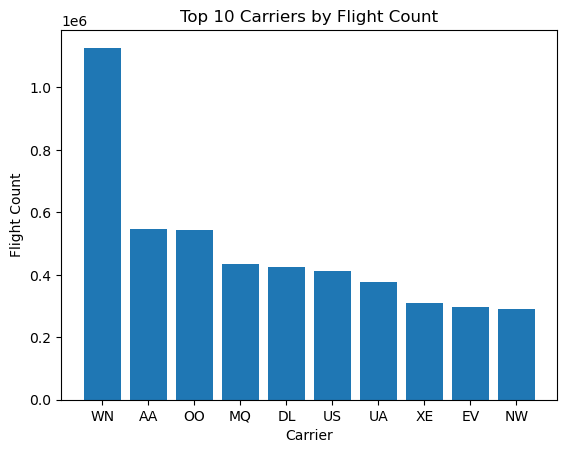

In [10]:
top_carriers = df_cleaned.groupBy("UniqueCarrier").count().orderBy(F.desc("count")).limit(10)
print("Top 10 carriers by flight count:")
top_carriers.show()

import matplotlib.pyplot as plt

pdf = top_carriers.toPandas()
plt.figure()
plt.bar(pdf['UniqueCarrier'], pdf['count'])
plt.title('Top 10 Carriers by Flight Count')
plt.xlabel('Carrier')
plt.ylabel('Flight Count')
plt.show()

Cancellation reasons
+----------------+-----+
|CancellationCode|count|
+----------------+-----+
|               B|36651|
|               A|35568|
|               C|14799|
|               D|   20|
+----------------+-----+



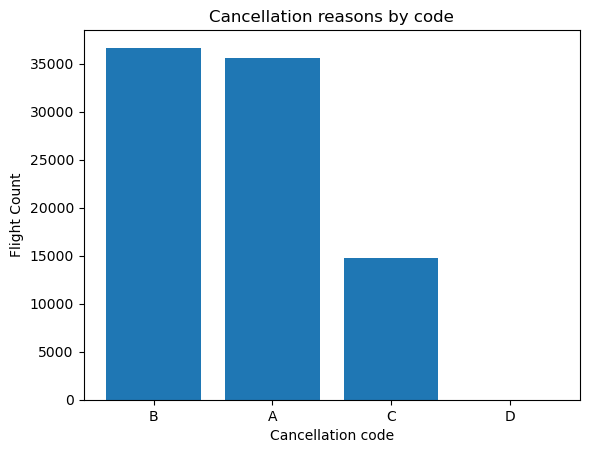

In [11]:
cancellation_counts = df_cleaned.filter(F.col("Cancelled") == 1.0) \
                        .groupBy("CancellationCode").count().orderBy(F.desc("count")).limit(10)

print("Cancellation reasons")
cancellation_counts.show()

pdf = cancellation_counts.toPandas()
plt.figure()
plt.bar(pdf['CancellationCode'], pdf['count'])
plt.title('Cancellation reasons by code')
plt.xlabel('Cancellation code')
plt.ylabel('Flight Count')
plt.show()

In [12]:
total_count = cancellation_counts.agg(F.sum("count")).collect()[0][0]

df = cancellation_counts.withColumn("distribution", (F.col("count") / total_count) * 100)

max_count = df.agg(F.max("count")).collect()[0][0]
min_count = df.agg(F.min("count")).collect()[0][0]
imbalance_ratio = max_count / min_count

print("Class distribution")
df.show()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")


Class distribution
+----------------+-----+--------------------+
|CancellationCode|count|        distribution|
+----------------+-----+--------------------+
|               B|36651|   42.10919368551667|
|               A|35568|    40.8649095797238|
|               C|14799|  17.002918265585144|
|               D|   20|0.022978469174383603|
+----------------+-----+--------------------+

Imbalance Ratio: 1832.55


## Task 4

In [13]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

In [14]:
def preprocess_dataframe(df):
    numeric_columns = [
        "Distance", "TaxiOut", "TaxiIn", "ScheduledElapsedTime", 
        "ActualElapsedTime", "AirTime", "DepartureDelay", "ArrivalDelay"
    ]
    
    for col_name in numeric_columns:
        df = df.withColumn(col_name, F.col(col_name).cast(DoubleType()))
    
    return df

In [15]:
categorical_features = ["UniqueCarrier", "Origin", "Destination", "FlightNum"]

temporal_features = ["DayOfWeek", "Month"]

numerical_features = [
    "Distance",
    "TaxiOut",
    "TaxiIn",
    "ScheduledElapsedTime",
    "AirTime",
    "DepartureDelay"
]

indexers = [
    StringIndexer(
        inputCol=col, 
        outputCol=f"{col}Index",
        handleInvalid="keep"
    ) for col in categorical_features
]

encoder_inputs = [f"{col}Index" for col in categorical_features]
encoder_outputs = [f"{col}Vec" for col in categorical_features]
encoder = OneHotEncoder(
    inputCols=encoder_inputs,
    outputCols=encoder_outputs,
    dropLast=True
)

In [16]:
assembler_inputs = encoder_outputs + temporal_features + numerical_features
assembler = VectorAssembler(
    inputCols=assembler_inputs,
    outputCol="features",
    handleInvalid="keep"
)


In [49]:
pipeline = Pipeline(stages=indexers + [encoder, assembler])

df_preprocessed = preprocess_dataframe(df_cleaned)

pipeline_model = pipeline.fit(df_preprocessed)

df_features = pipeline_model.transform(df_preprocessed)

In [18]:
df_features.select("UniqueCarrier", "Origin", "Destination", "ArrivalDelay", "features").show(3, truncate=False)

feature_cols = encoder_outputs + temporal_features + numerical_features
print(f"Features included in the vector: {feature_cols}")

print("\nBreakdown of feature vector contents:")
print(f"- Categorical features (one-hot encoded): {encoder_outputs}")
print(f"- Temporal features: {temporal_features}")
print(f"- Numerical features: {numerical_features}")

+-------------+------+-----------+------------+------------------------------------------------------------------------------------------------------------------------+
|UniqueCarrier|Origin|Destination|ArrivalDelay|features                                                                                                                |
+-------------+------+-----------+------------+------------------------------------------------------------------------------------------------------------------------+
|WN           |ABQ   |BWI        |-27.0       |(7963,[0,67,332,981,7955,7956,7957,7958,7959,7960,7961,7962],[1.0,1.0,1.0,1.0,6.0,7.0,1670.0,7.0,4.0,230.0,193.0,-1.0]) |
|WN           |ABQ   |BWI        |1.0         |(7963,[0,67,332,3425,7955,7956,7957,7958,7959,7960,7961,7962],[1.0,1.0,1.0,1.0,6.0,7.0,1670.0,5.0,3.0,230.0,226.0,-3.0])|
|WN           |ABQ   |DAL        |-8.0        |(7963,[0,67,355,687,7955,7956,7957,7958,7959,7960,7961,7962],[1.0,1.0,1.0,1.0,6.0,7.0,580.0,6.0,4.0,105.0,79

Feature Selection Decisions:

1. Categorical Features:
   - UniqueCarrier: Different airlines have different performance metrics
   - Origin/Destination: Airports have different weather patterns
   - FlightNum: Flight numbers may correlate with specific routes or aircraft types

2. Temporal Features:
   - DayOfWeek: Flight patterns vary by day of the week
   - Month: Seasonal variations in flight performance

3. Numerical Features:
   - Distance: Directly impacts flight time and potential for delays
   - TaxiOut/TaxiIn: Airport ground operations time
   - ScheduledElapsedTime: Baseline for expected flight duration
   - AirTime: Actual time in the air
   - DepartureDelay: Delays at departure often impact arrival time

4. Features Not Selected:
   - FlightDate: Redundant with DayOfWeek and Month
   - ScheduledDepartureTime/ArrivalTime: Could be useful but would need 
     time-of-day extraction first (e.g., morning vs. evening flights)
   - Cancelled and Diverted: Records are already filtered for these
   - WheelsOff/WheelsOn: Redundant with other time metrics
   - CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay: 
     These would cause data leakage if predicting arrival delays as they're only 
     known after a flight is completed

5. Data Type Handling:
   - Most numerical columns are stored as strings in the dataset
   - Added preprocessing step to convert string columns to proper numeric types

6. Preprocessing Pipeline:
   - Preprocessing: Convert string columns to appropriate numeric types
   - StringIndexer: Converts categorical strings to numerical indices
   - OneHotEncoder: Creates binary vectors to properly represent categorical data
   - VectorAssembler: Combines all features into a single feature vector for modeling

## Task 5

In [19]:
# Split data 70/30 train/test (seed 42)
df_model = df_features.withColumn("label", F.col("Cancelled").cast("double"))
split_ratio = [0.7, 0.3]
seed = 42 
train_data, test_data = df_model.randomSplit(split_ratio, seed=seed)

# Cache the splits for performance during training and evaluation
# train_data.cache()
# test_data.cache()

# print(f"Training data count: {train_data.count()} ({(train_data.count() / df_model.count())*100:.1f}%)")
# print(f"Test data count: {test_data.count()} ({(test_data.count() / df_model.count())*100:.1f}%)")


In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pyspark.sql.functions as F

# Evaluator for binary classification, typically uses rawPrediction for AUC by default
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

# Define a reusable training and evaluation function for model
def train_and_evaluate(model, param_grid, name):
    print(f"\nTraining {name}...")
    cv = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=3, #3-fold cross-validation
        seed=42,
        parallelism=4 # train 4 models in parallel (if allows)
    )
    best_model = cv.fit(train_data) # fit the model on the training data
    predictions = best_model.transform(test_data) #Use the best model to make predictions on the test data

    # Evaluate Area Under ROC (AUC) and compute accuracy manually
    auc = evaluator.evaluate(predictions)
    accuracy = predictions.filter(F.col("label") == F.col("prediction")).count() / predictions.count()
    print(f"{name} - AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")
    return name, auc, accuracy, best_model

In [21]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
# choose one hyperparameter for each model since data is very big
# put models to separate cells to run separately
# add results here
results = []

# Logistic Regression
lr = LogisticRegression(labelCol="label", featuresCol="features")
lr_grid = ParamGridBuilder().addGrid(lr.regParam, [0.1]).build() # prevent overfitting
results.append(train_and_evaluate(lr, lr_grid, "Logistic Regression"))


Training Logistic Regression...
Logistic Regression - AUC: 0.9946, Accuracy: 0.9864


In [22]:
# Decision Tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_grid = ParamGridBuilder().addGrid(dt.maxDepth, [5]).build() # limit how deep tree grows
results.append(train_and_evaluate(dt, dt_grid, "Decision Tree"))


Training Decision Tree...
Decision Tree - AUC: 1.0000, Accuracy: 1.0000


In [23]:
# Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rf_grid = ParamGridBuilder().addGrid(rf.numTrees, [20]).build() #. how many trees to build
results.append(train_and_evaluate(rf, rf_grid, "Random Forest"))


Training Random Forest...
Random Forest - AUC: 1.0000, Accuracy: 0.9864


In [24]:
# GBT
gbt = GBTClassifier(labelCol="label", featuresCol="features")
gbt_grid = ParamGridBuilder().addGrid(gbt.maxIter, [10]).build() # maximum number of iterations for the optimization algorithm
results.append(train_and_evaluate(gbt, gbt_grid, "GBT"))


Training GBT...
GBT - AUC: 1.0000, Accuracy: 1.0000


In [25]:
spark.stop()

In [32]:
results

[('Logistic Regression', 0.9945903042495142, 0.9864493377968689),
 ('Decision Tree', 0.9999989462509202, 0.9999974016984577),
 ('Random Forest', 0.999983848544537, 0.9864493377968689),
 ('GBT', 0.999999209306869, 0.9999963623778408)]

## Task 6

In [24]:
name, auc, accuracy, best_model = train_and_evaluate(dt, dt_grid, "Decision Tree")


Training Decision Tree...
Decision Tree - AUC: 1.0000, Accuracy: 1.0000


In [26]:
best_model.bestModel.featureImportances

SparseVector(7963, {5973: 0.0, 7958: 0.0069, 7959: 0.8032, 7961: 0.1899, 7962: 0.0})

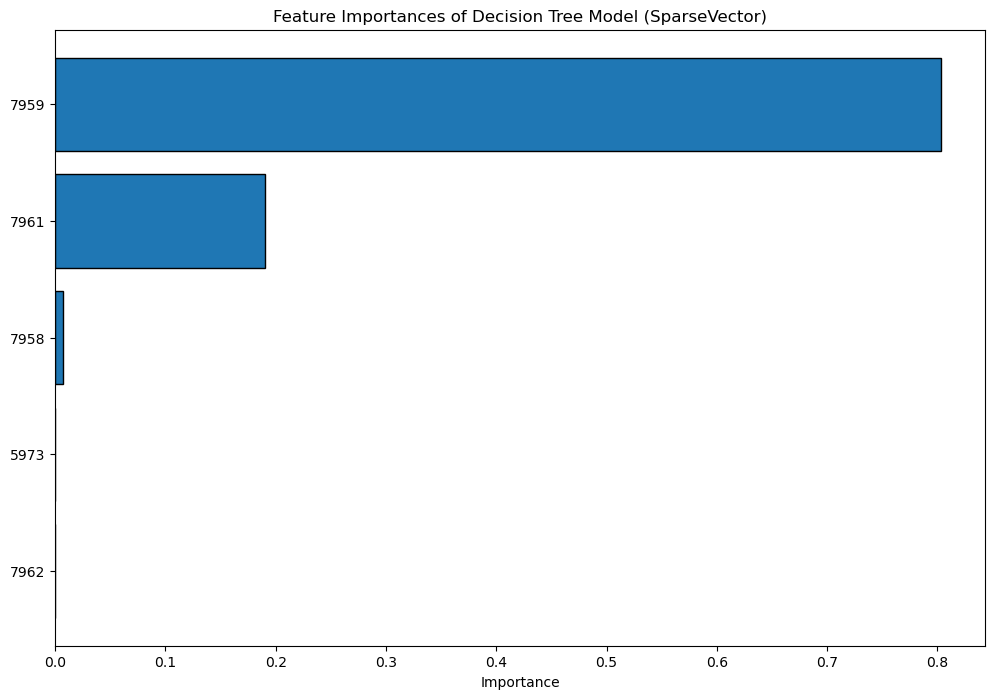

In [34]:
import pandas as pd

feature_importances = best_model.bestModel.featureImportances  # This is your SparseVector

importance_df = pd.DataFrame({
    "Feature_Index": feature_importances.indices,
    "Importance": feature_importances.values
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature_Index"].astype(str), importance_df["Importance"], edgecolor="black")
plt.xlabel("Importance")
plt.title("Feature Importances of Decision Tree Model (SparseVector)")
plt.gca().invert_yaxis()
plt.show()

## Task 7

In [39]:
## Save best model
best_model.bestModel.save("./best_model")

In [46]:
## Begin 2010 Scoring

df_2010 = spark.read.csv('./data/2010.csv', header=True, inferSchema=True)

In [63]:
df_2010_r = df_2010 \
    .withColumnRenamed("FL_DATE", "FlightDate") \
    .withColumnRenamed("OP_CARRIER", "UniqueCarrier") \
    .withColumnRenamed("OP_CARRIER_FL_NUM", "FlightNum") \
    .withColumnRenamed("ORIGIN", "Origin") \
    .withColumnRenamed("DEST", "Destination") \
    .withColumnRenamed("CRS_DEP_TIME", "ScheduledDepartureTime") \
    .withColumnRenamed("DEP_TIME", "DepartureTime") \
    .withColumnRenamed("DEP_DELAY", "DepartureDelay") \
    .withColumnRenamed("TAXI_OUT", "TaxiOut") \
    .withColumnRenamed("WHEELS_OFF", "WheelsOff") \
    .withColumnRenamed("WHEELS_ON", "WheelsOn") \
    .withColumnRenamed("TAXI_IN", "TaxiIn") \
    .withColumnRenamed("CRS_ARR_TIME", "ScheduledArrivalTime") \
    .withColumnRenamed("ARR_TIME", "ArrivalTime") \
    .withColumnRenamed("ARR_DELAY", "ArrivalDelay") \
    .withColumnRenamed("CANCELLED", "Cancelled") \
    .withColumnRenamed("CANCELLATION_CODE", "CancellationCode") \
    .withColumnRenamed("DIVERTED", "Diverted") \
    .withColumnRenamed("CRS_ELAPSED_TIME", "ScheduledElapsedTime") \
    .withColumnRenamed("ACTUAL_ELAPSED_TIME", "ActualElapsedTime") \
    .withColumnRenamed("AIR_TIME", "AirTime") \
    .withColumnRenamed("DISTANCE", "Distance") \
    .withColumnRenamed("CARRIER_DELAY", "CarrierDelay") \
    .withColumnRenamed("WEATHER_DELAY", "WeatherDelay") \
    .withColumnRenamed("NAS_DELAY", "NASDelay") \
    .withColumnRenamed("SECURITY_DELAY", "SecurityDelay") \
    .withColumnRenamed("LATE_AIRCRAFT_DELAY", "LateAircraftDelay") \
    .withColumn("DayOfWeek", F.dayofweek(F.col("FlightDate"))) \
    .withColumn("Month", F.month(F.col("FlightDate"))) \
    .drop("Unnamed: 27")

In [64]:
df_2010_t = pipeline_model.transform(df_2010_r)

In [66]:
 df_2010_scored = best_model.transform(df_2010_t)

In [72]:
df_2010_scored.orderBy(F.desc("prediction")).select("FlightDate", "UniqueCarrier", "FlightNum", "Origin", "Destination", "prediction").show(100)

+----------+-------------+---------+------+-----------+----------+
|FlightDate|UniqueCarrier|FlightNum|Origin|Destination|prediction|
+----------+-------------+---------+------+-----------+----------+
|2010-12-20|           OO|     6461|   YUM|        IPL|       1.0|
|2010-07-26|           OO|     6461|   YUM|        IPL|       1.0|
|2010-12-03|           OO|     6662|   MRY|        SFO|       1.0|
|2010-07-26|           OO|     6662|   MRY|        SFO|       1.0|
|2010-01-10|           OO|     6684|   CEC|        ACV|       1.0|
|2010-10-04|           OO|     6645|   MOD|        SFO|       1.0|
|2010-01-11|           OO|     6679|   MRY|        SFO|       1.0|
|2010-09-14|           AS|       64|   PSG|        WRG|       1.0|
|2010-04-22|           OO|     5885|   ACV|        CEC|       1.0|
|2010-09-17|           OO|     6461|   YUM|        IPL|       1.0|
|2010-09-03|           OO|     6461|   YUM|        IPL|       1.0|
|2010-06-15|           OO|     6645|   MOD|        SFO|       